In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle, zip_longest
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.fft as fft
import seaborn as sns
sns.set()

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import sys
sys.path.append("/home/evangelos/workspace/Channel_Charting/")
from tools import utils
from src.models import supervised_classifier, supervised_regressor
from src.utils.data_preparation import SupervisedDataset

def preprocessing(data, first_data, rx_positions=None, padding=True, reduce=False, keep_idces=None):
    data = data[keep_idces]
    if rx_positions:
        data = utils.drop_top_right(data, rx_positions)
    data = utils.standarize(data)
    data = utils.fillna(data)
    if padding:
        data = utils.zero_padding_as(data, first_data)
    #data = utils.take_norm(data)
    if reduce:
        data = reduce_to_mean_std(data)
    
    return data

def reduce_to_mean_std(x):
    return np.stack([np.mean(x,axis=1), 
                          np.std(x,axis=1)], axis=1)

def get_k_best(predictions, K):
    """Function that return the indices of most K most confident predictions"""
    K_preds = sorted(list(enumerate(predictions.max(dim=1).values.detach())), key=lambda x: x[1], reverse=True)[:K]
    return [x[0] for x in K_preds]

def get_k_worst(predictions, K):
    """Function that return the indices of most K most confident predictions"""
    K_preds = sorted(list(enumerate(predictions.max(dim=1).values.detach())), key=lambda x: x[1], reverse=False)[:K]
    return [x[0] for x in K_preds]

# Introduction

In this notebook I explore the possibility of training a classifier model for Channel Charting using semi-supervised learning. I use the same preprocessing as in the supervised setting. The idea is to see if with a small number of labeled samples we are able to generate predictions of comparable accuracy to the supervised method.

In [2]:
# configuration
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
batch_size = 64
train_size = 0.05
n_clusters = 8
K_best = 250
drop_top_right = False
custom_labels = True

In [3]:
# load datasets
(raw_taps, raw_phi, raw_theta, raw_rx_positions, raw_tx_positions) = utils.load_datasets()

In [4]:
#fourier transform and undersample taps
raw_freq_taps = fft.fft(raw_taps , workers=-1)[:,:,::2]

In [5]:
#get indices for tap outliers
mean_freq = np.mean(raw_freq_taps, axis=(1,2))
mu = np.mean(mean_freq)
std = np.std(mean_freq)
idces = ~(np.abs(mean_freq-mu) >2*std)

if drop_top_right:
    pos = raw_rx_positions
else:
    pos = None

In [6]:
taps = preprocessing(raw_freq_taps, raw_freq_taps,rx_positions=pos , keep_idces=idces)
taps = np.hstack([np.real(taps), np.imag(taps)])

In [7]:
phi = preprocessing(raw_phi, taps, rx_positions=pos , keep_idces=idces)

In [8]:
theta = preprocessing(raw_theta, taps, rx_positions=pos , keep_idces=idces)

In [9]:
y  = preprocessing(raw_rx_positions, taps, rx_positions=pos , keep_idces=idces, padding=False)[:,:2]

In [10]:
X = np.hstack([taps, phi[:-10], theta[:-10]])
X.shape

(23687, 84, 50)

In [11]:
#assign labels to certain areas of the map using kmeans
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MiniBatchKMeans
km = MiniBatchKMeans(n_clusters=n_clusters) 
km = km.fit(y)
labels = km.predict(y)

In [19]:
def in_alley(x,y):
    f1 = lambda x: 3.2*x - 3.8
    f2 = lambda x: 3.2*x - 5.8
    x_2 = np.linspace(0.6,1.8)
    x_min = x_2.min()
    x_max = x_2.max()+0.62
    if (x>=x_min and x<x_max):
        if (f1(x)>=y and f2(x)<=y):
            return True
    return False

if custom_labels:
    alley_list = [in_alley(y_[0], y_[1]) for y_ in y]
    labels[alley_list] = 2

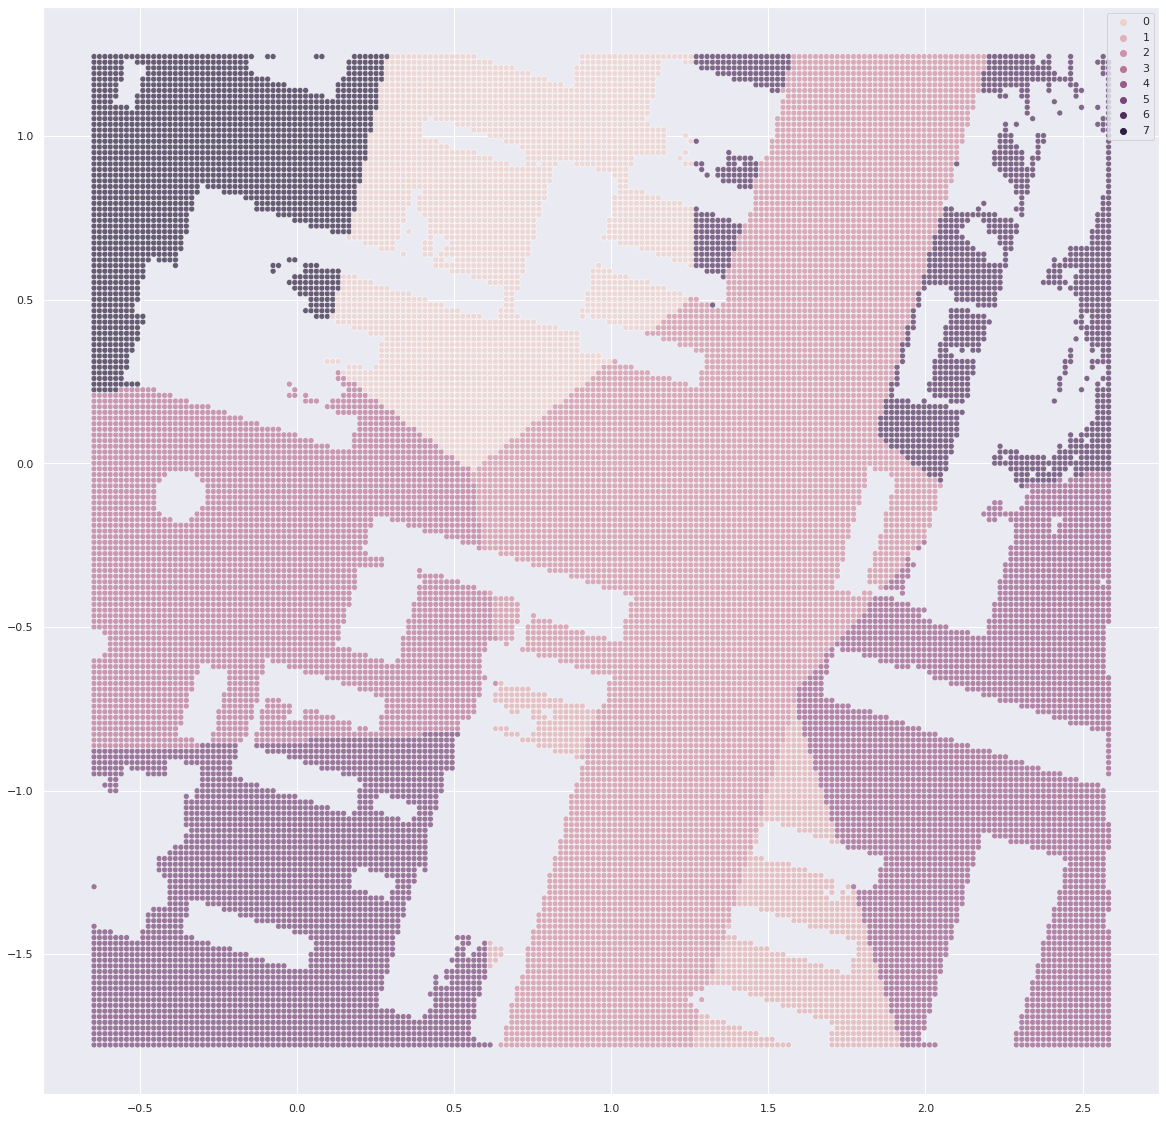

In [20]:
plt.figure(figsize=(20,20))
sns.scatterplot(y[:,0], y[:,1], hue=labels, legend="full", alpha=0.7)

# Semi Supervised Learning

## Mean Teacher

Algorithm

For minibatch in dataset:
    1. Take 2 identical models(teacher, student)
    2. use both labeled and unlabeled dataset
        1. if labeled:
        use classification cost and consistency cost and add them
        2. if unlabeled
        use only consistency cost
    3. optimize student as normal and use exponential average to update weights for teacher


In [21]:
def EMA_update(teacher_params, student_params, alpha=0.01):
    for teacher_param, student_param in zip(teacher_params, student_params):
        teacher_param.data = alpha*teacher_param.data + (1-alpha)*student_param.data

In [34]:
#train test split
# keep 25% of the dataset for testing
train_X, test_X ,train_y, test_y, train_labels, test_labels = train_test_split(X, y, labels)
test_DS = SupervisedDataset(test_X, test_labels)
test_loader = DataLoader(test_DS, batch_size=batch_size)

# use 2500 ~ 10% of the original dataset as labeled dataset
(X_labelled, X_unlabelled, 
 _, _, 
 labels_sampled, labels_unlabelled) = train_test_split(train_X, 
                                                      train_y, 
                                                      train_labels, 
                                                      train_size=train_size)
labelled_DS = SupervisedDataset(X_labelled, labels_sampled)
unlabelled_DS = SupervisedDataset(X_unlabelled, labels_unlabelled)

labelled_loader = DataLoader(labelled_DS, batch_size=int(train_size*batch_size))
unlabelled_loader = DataLoader(unlabelled_DS, batch_size=batch_size)

#initialize student and teacher models
teacher = supervised_classifier.Classifier(channels=labelled_DS.channels(), nb_labels=n_clusters)
student = supervised_classifier.Classifier(channels=labelled_DS.channels(), nb_labels=n_clusters)
#initialize optimizer for student
optimizer = torch.optim.Adam(student.parameters())
#classification and consistence criterions
classification_criterion = torch.nn.CrossEntropyLoss()
consistency_criterion = torch.nn.MSELoss()

In [73]:
best_teacher_val_loss, best_student_val_loss = 9999, 9999
patience = 3
for e in range(50):
    #train
    count=0 #counter for early stopping
    loss = 0
    teacher_loss = 0
    for labeled, unlabeled in zip_longest(labelled_loader, unlabelled_loader):
        # for labeled
        optimizer.zero_grad()
        if labeled:
            y_hat_1 = teacher(labeled[0])
            y_hat_2 = student(labeled[0])
            
            class_loss = classification_criterion(y_hat_2, labeled[1].long())
            teacher_batch_loss = classification_criterion(y_hat_1, labeled[1].long())
            cons_loss = consistency_criterion(torch.softmax(y_hat_2, dim=1), 
                                              torch.softmax(y_hat_1, dim=1))
            batch_loss = cons_loss+class_loss

            batch_loss.backward()
            optimizer.step()

            EMA_update(teacher.parameters(), student.parameters(), 0.01)
            loss+=batch_loss.item()

        # for unlabeled
        if unlabeled:
            y_hat_1 = teacher(unlabeled[0])
            y_hat_2 = student(unlabeled[0])
            cons_loss = consistency_criterion(torch.softmax(y_hat_2, dim=1),
                                              torch.softmax(y_hat_1, dim=1))

            batch_loss = cons_loss
            batch_loss.backward()
            optimizer.step()

            EMA_update(teacher.parameters(), student.parameters(), 0.01)

            loss+=batch_loss.item()
            teacher_loss+=teacher_batch_loss.item()
    #test
    teacher_yhats = teacher(test_DS[:][0])
    student_yhats = student(test_DS[:][0])
    
    teacher_val_loss = classification_criterion(teacher_yhats, torch.LongTensor(test_labels))
    student_val_loss = classification_criterion(student_yhats, torch.LongTensor(test_labels))
    
    #early stopping
    if (teacher_val_loss>best_teacher_val_loss and student_val_loss>best_student_val_loss):
        count+=1
        print(f"Early Stopping Count: {patience-count}")
    elif (teacher_val_loss>best_teacher_val_loss or student_val_loss>best_student_val_loss):
        count+=0.5
        print(f"Early Stopping Count: {patience-count}")

        if teacher_val_loss<best_teacher_val_loss:
            best_teacher_val_loss = teacher_val_loss
        else:
            best_student_val_loss = student_val_loss
    else:
        best_student_val_loss, best_teacher_val_loss = student_val_loss, teacher_val_loss
        count=0   
    if count>patience-1:
        break
        

    
    print(f"Epoch {e},Student Loss: {loss:.3f}, Teacher Class_loss: {teacher_loss:.3f}, Student Val Loss: {student_val_loss.item():.3f}, Teacher Val Loss: {teacher_val_loss.item():.3f}")

Epoch 0,Student Loss: 206.937, Teacher Class_loss: 174.483, Student Val Loss: 1.910, Teacher Val Loss: 1.918
Epoch 1,Student Loss: 200.503, Teacher Class_loss: 169.344, Student Val Loss: 1.893, Teacher Val Loss: 1.900
Early Stopping Count: 2
Epoch 2,Student Loss: 225.660, Teacher Class_loss: 182.598, Student Val Loss: 1.924, Teacher Val Loss: 1.963
Early Stopping Count: 2.5
Epoch 3,Student Loss: 207.202, Teacher Class_loss: 176.684, Student Val Loss: 1.931, Teacher Val Loss: 1.883
Early Stopping Count: 2
Epoch 4,Student Loss: 209.752, Teacher Class_loss: 175.344, Student Val Loss: 2.031, Teacher Val Loss: 2.056
Early Stopping Count: 2
Epoch 5,Student Loss: 204.344, Teacher Class_loss: 162.714, Student Val Loss: 1.924, Teacher Val Loss: 1.920
Early Stopping Count: 2
Epoch 6,Student Loss: 210.662, Teacher Class_loss: 183.045, Student Val Loss: 1.969, Teacher Val Loss: 1.966
Early Stopping Count: 2
Epoch 7,Student Loss: 191.749, Teacher Class_loss: 170.121, Student Val Loss: 2.029, Teache

KeyboardInterrupt: 

In [74]:
teacher_yhats = teacher(test_DS[:][0]).detach().argmax(dim=1)
student_yhats = student(test_DS[:][0]).detach().argmax(dim=1)

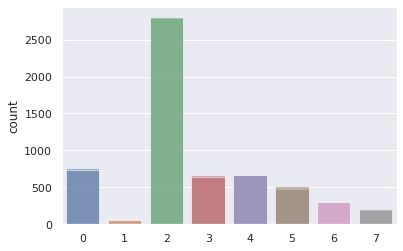

In [75]:
sns.countplot(teacher_yhats.detach().numpy(), label='Teacher', alpha=0.5)
sns.countplot(student_yhats.detach().numpy(), label='Student', alpha=0.5)

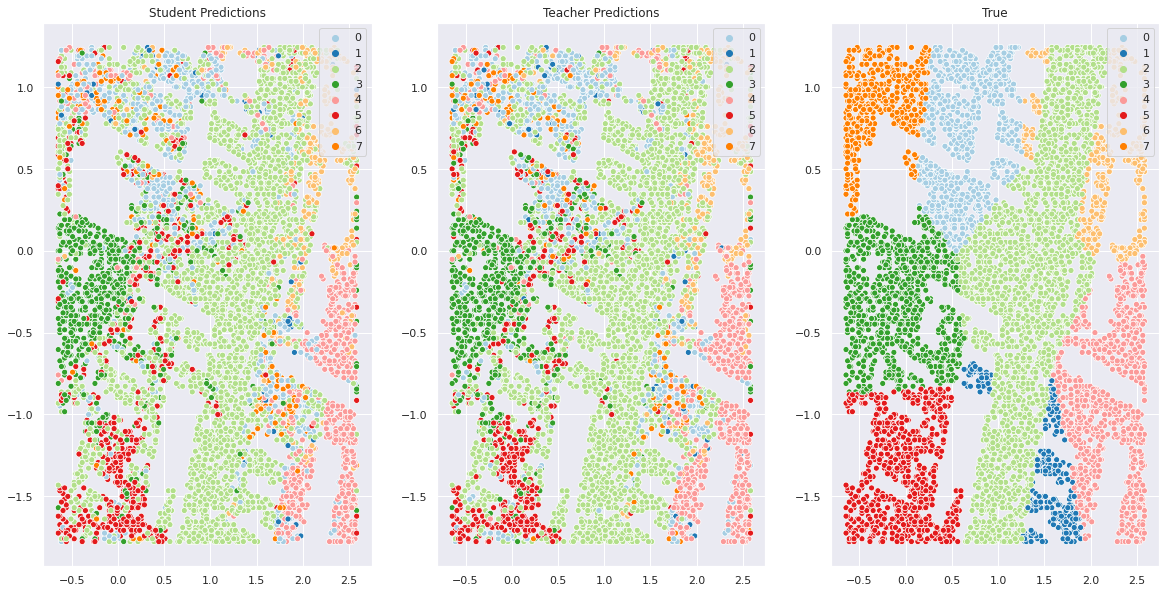

In [76]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title("Student Predictions")
sns.scatterplot(test_y[:,0], test_y[:,1], hue=student_yhats, legend="full", palette='Paired')
plt.subplot(1,3,2)
plt.title("Teacher Predictions")
sns.scatterplot(test_y[:,0], test_y[:,1], hue=teacher_yhats, legend="full", palette='Paired')
plt.subplot(1,3,3)
plt.title("True")
sns.scatterplot(test_y[:,0], test_y[:,1], hue=test_labels, legend="full", palette='Paired')
plt.show()

In [81]:
len(labelled_DS), len(unlabelled_DS)

(888, 16877)

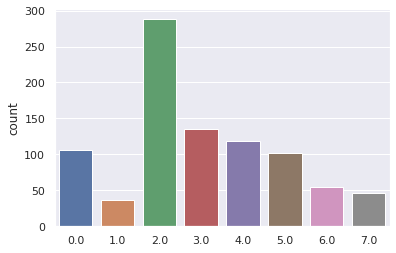

In [84]:
sns.countplot(labelled_DS[:][1].numpy())

In [78]:
print(classification_report(teacher_yhats, test_labels))

              precision    recall  f1-score   support

           0       0.41      0.38      0.39       765
           1       0.01      0.05      0.02        61
           2       0.81      0.58      0.68      2797
           3       0.59      0.74      0.66       661
           4       0.66      0.76      0.70       670
           5       0.42      0.55      0.48       483
           6       0.52      0.56      0.54       296
           7       0.14      0.32      0.20       189

    accuracy                           0.58      5922
   macro avg       0.45      0.49      0.46      5922
weighted avg       0.64      0.58      0.60      5922



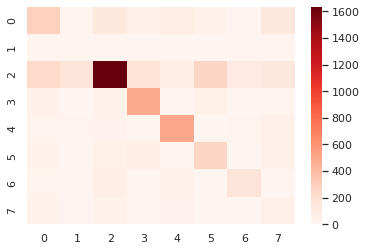

In [79]:
sns.heatmap(confusion_matrix(teacher_yhats, test_labels), cmap='Reds')
plt.show()